In [1]:
import os
import inspect
import pickle as pkl
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MultipleLocator

In [2]:
main_path = '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/'

fullpath_osc_rng = main_path + 'batch1024_osc_len16_withGT_11A15E63D82B4CFE85B1B56DF8F07893.pkl'
with open(fullpath_osc_rng, 'rb') as f:
    rng_osc_data = pkl.load(f)  
print(rng_osc_data["config"])

# fullpath_SSI = main_path + 'trajs.pkl'
# with open(fullpath_SSI, 'rb') as f:
#     SSI_data = pkl.load(f)  
# print(SSI_data["config"])

# fullpath_rng = main_path + 'batch1600_len16_withGT_A9B0C901C77E43268217455A84EE4D39.pkl'
# with open(fullpath_rng, 'rb') as f:
#     rng_data = pkl.load(f)  
# print(rng_data["config"])

{'n_actions': 2, 'action_scale': 0.01, 'initial_qpos': [0.4210615413263448, -1.6685631515278796, -2.746929932488106, -0.29617014014198634, 1.570470494473659, 0.4202644449684555], 'fixed': True, 'goal_vis': False, 'enable_ft': True, 'randomize_init': False, 'randomize_goal': False, 'randomize_object': False, 'is_render': False, 'goal_threshold': 0.05, 'controller': 'position', 'max_episode_steps': 200, 'render_w': 64, 'render_h': 64, 'ball_r': 0.02, 'gravity': 9.81, 'frame_skip': 2, 'timestep': 0.004166666666666667, 'solver_it': 50, 'substeps': 32, 'plate_URDF': 'assets/objects/plate.urdf'}


In [3]:
class Visualizer():
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data["img"].shape[0]
    
    def __repr__(self):
        fmt_str = 'Dataset Statistics:' + '\n'
        fmt_str += '    Number of trajectories: {}\n'.format(self.batch_size)
        fmt_str += '    Trajectory length: {}\n'.format(self.traj_len)
        fmt_str += '    Data keys and shapes: {}\n'.format(str([f"{k}: {v.shape}" for k, v in self.data.items() if type(v) == np.ndarray]))
        return fmt_str

    def animate_traj(self, traj):    
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,5))
        ft = self.data["ft"][traj]
        img = self.data["img"][traj]
        m = ft.shape[1]
        n = img.shape[0]

        ft = ft.reshape(-1, *ft.shape[2:])
        x = np.arange(n * m)
        y0 = ft[:, 0]
        y1 = ft[:, 1]
        y2 = ft[:, 2]
        line0, = ax2.plot(x[0], y0[0], label='x')
        line1, = ax2.plot(x[0], y1[0], label='y')
        line2, = ax2.plot(x[0], y2[0], label='z')
        ax2.set_ylim(-200, 200)
        ax2.set_xlim(0, 512)
        ax2.set_title("Forces")
        ax2.legend()
        y3 = ft[:, 3]
        y4 = ft[:, 4]
        y5 = ft[:, 5]
        line3, = ax3.plot(x[0], y3[0], label='x')
        line4, = ax3.plot(x[0], y4[0], label='y')
        line5, = ax3.plot(x[0], y5[0], label='z')
        ax3.set_ylim(-200, 200)
        ax3.set_xlim(0, 512)
        ax3.set_title("Torques")
        ax3.legend()

        ax2.xaxis.set_major_locator(MultipleLocator(32))
        ax3.xaxis.set_major_locator(MultipleLocator(32))
        ax2.grid(which='major', color='#CCCCCC', linestyle='--')
        ax3.grid(which='major', color='#CCCCCC', linestyle='--')
        ax2.tick_params(axis="x", labelsize=8, labelrotation=90)
        ax3.tick_params(axis="x", labelsize=8, labelrotation=90)
        ax2.tick_params(axis="y", labelsize=8)
        ax3.tick_params(axis="y", labelsize=8)

        im = ax1.imshow(img[0], animated=True)
        ax1.set_axis_off()

        def update(i, x, y0, y1, y2, y3, y4, y5, 
                   line0, line1, line2, line3, line4, line5, im):
            if i % m == 0:
                im.set_array(img[int(i / m)])
            line0.set_data(x[:i], y0[:i])
            line1.set_data(x[:i], y1[:i])
            line2.set_data(x[:i], y2[:i])
            line3.set_data(x[:i], y3[:i])
            line4.set_data(x[:i], y4[:i])
            line5.set_data(x[:i], y5[:i])
            ax1.set_title("Image t = {}".format(int(i / m)), fontsize=20)
            return line0, line1, line2, im

        anim = animation.FuncAnimation(fig, update, frames=(m * n), interval=2, 
                                       fargs=[x, y0, y1, y2, y3, y4, y5, 
                                              line0, line1, line2, line3, line4, line5, im], 
                                       blit=True)
        plt.show()
        return anim
    
class VisualPusherVisualizer(Visualizer):
    def __init__(self, data):
        super(VisualPusherVisualizer, self).__init__(
            data=data
        )        
        self.batch_size = self.data["img"].shape[0]
        self.traj_len = self.data["img"].shape[1]
        self.in_contact_ratio = self.time_in_contact()

    def __repr__(self):
        fmt_str = 'Dataset Statistics:' + '\n'
        fmt_str += '    Number of trajectories: {}\n'.format(self.batch_size)
        fmt_str += '    Trajectory length: {}\n'.format(self.traj_len)
        fmt_str += '    Percent of time steps in contact with plate: {}%\n'.format(self.in_contact_ratio * 100)
        fmt_str += '    Data keys and shapes: {}\n'.format(str([f"{k}: {v.shape}" for k, v in self.data.items() if type(v) == np.ndarray]))
        return fmt_str
    
    def time_in_contact(self, threshold=10):
        max_ft_per_t = np.linalg.norm(self.data["ft"], axis=-1).max(axis=-1)
        max_ft_per_t = max_ft_per_t.reshape(-1)
        in_contact_ratio = (np.sum(max_ft_per_t > threshold) / max_ft_per_t.size)
        return in_contact_ratio
    
    def contact_norm_hist(self):
        f, ax = plt.subplots(figsize=(6,6))
        
        max_ft_per_t = np.linalg.norm(self.data["ft"], axis=-1).max(axis=-1)
        max_ft_per_t = max_ft_per_t.reshape(-1)
        ax.hist(max_ft_per_t, bins=256) 
        # n, bins = np.histogram(max_ft_per_t, bins=256)
        # print(n, bins)
        ax.set_title("Histogram of contact force norms")
        return ax
    
    def plate_loc_heat_map(self):
        f, ax = plt.subplots(figsize=(6,6))

        # Generate some test data
        x = self.data["gt_plate_pos"].reshape(-1, *self.data["gt_plate_pos"].shape[2:])[:, 1]
        y = -self.data["gt_plate_pos"].reshape(-1, *self.data["gt_plate_pos"].shape[2:])[:, 0]

        l = 3
        
        ax.scatter(x, y, marker='o', s=0.5, alpha=0.50)
        ax.set_xlim(-0.15, 0.15)
        ax.set_ylim(-1.3, -0.75)
        ax.set_title("Heat map of plate positions")
        return ax


In [4]:
v = VisualPusherVisualizer(rng_osc_data)

Dataset Statistics:
    Number of trajectories: 1024
    Trajectory length: 16
    Percent of time steps in contact with plate: 76.544189453125%
    Data keys and shapes: ['img: (1024, 16, 64, 64, 3)', 'ft: (1024, 16, 32, 6)', 'arm: (1024, 16, 32, 6)', 'action: (1024, 16, 2)', 'gt_plate_pos: (1024, 16, 3)']



<IPython.core.display.Javascript object>


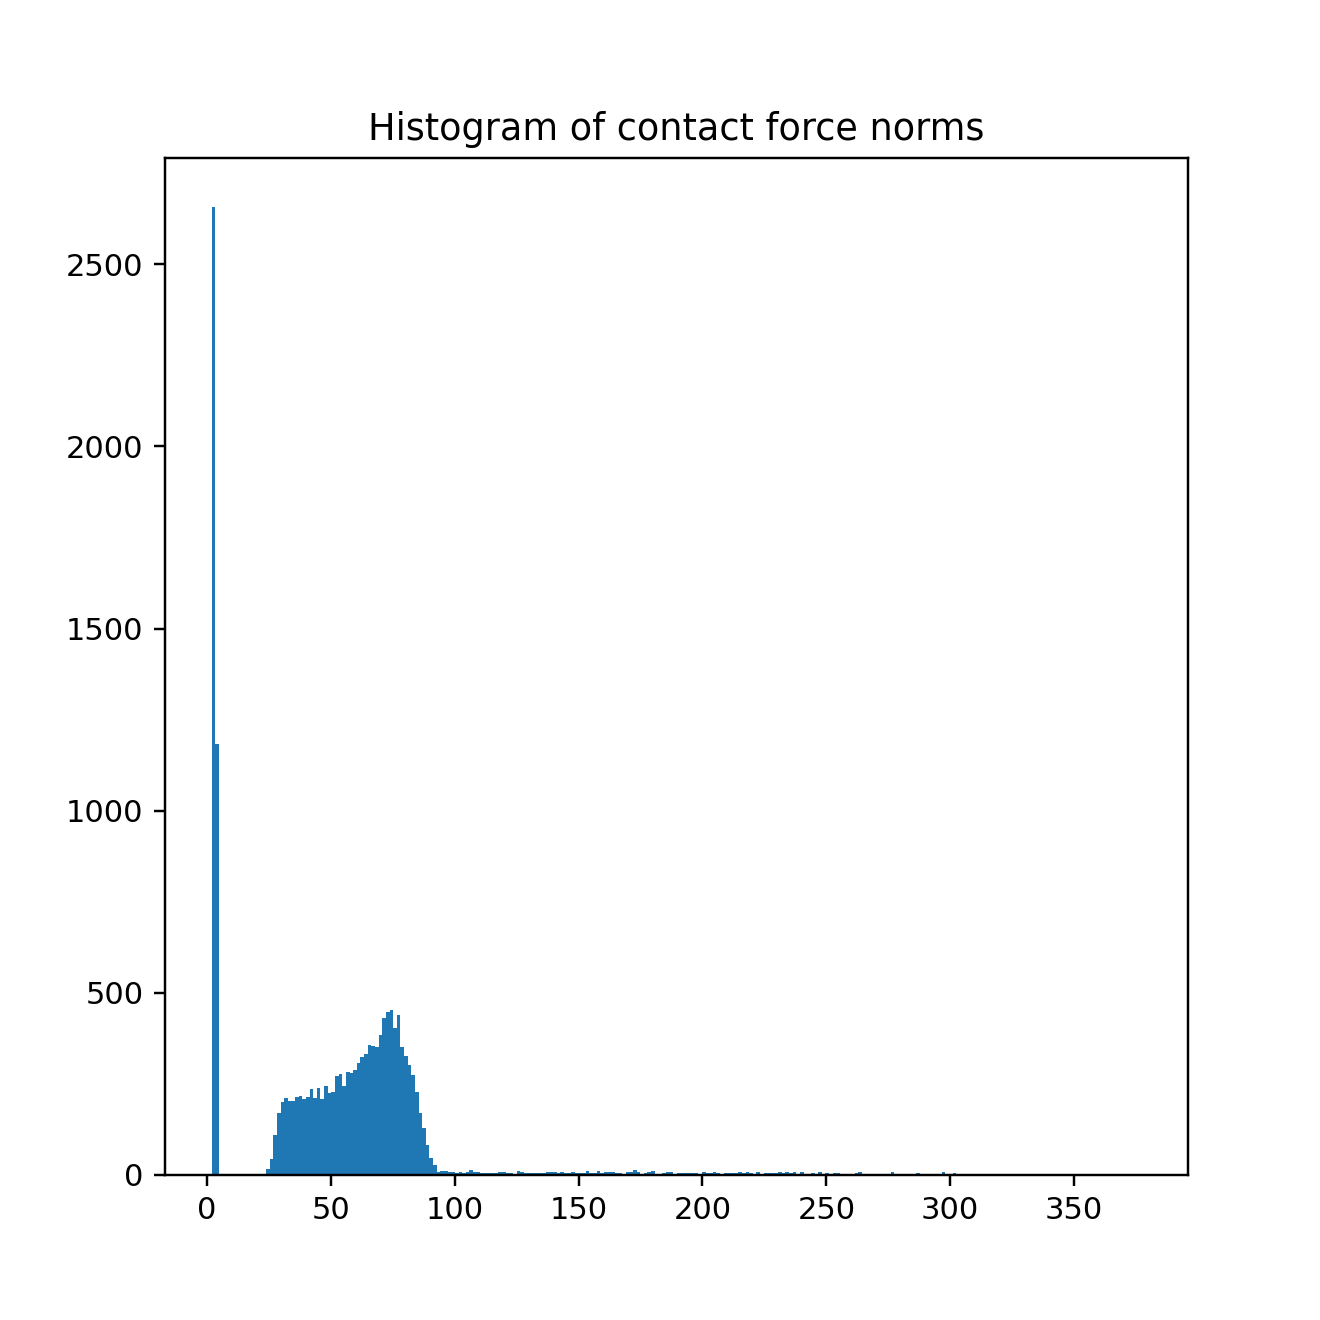

<IPython.core.display.Javascript object>


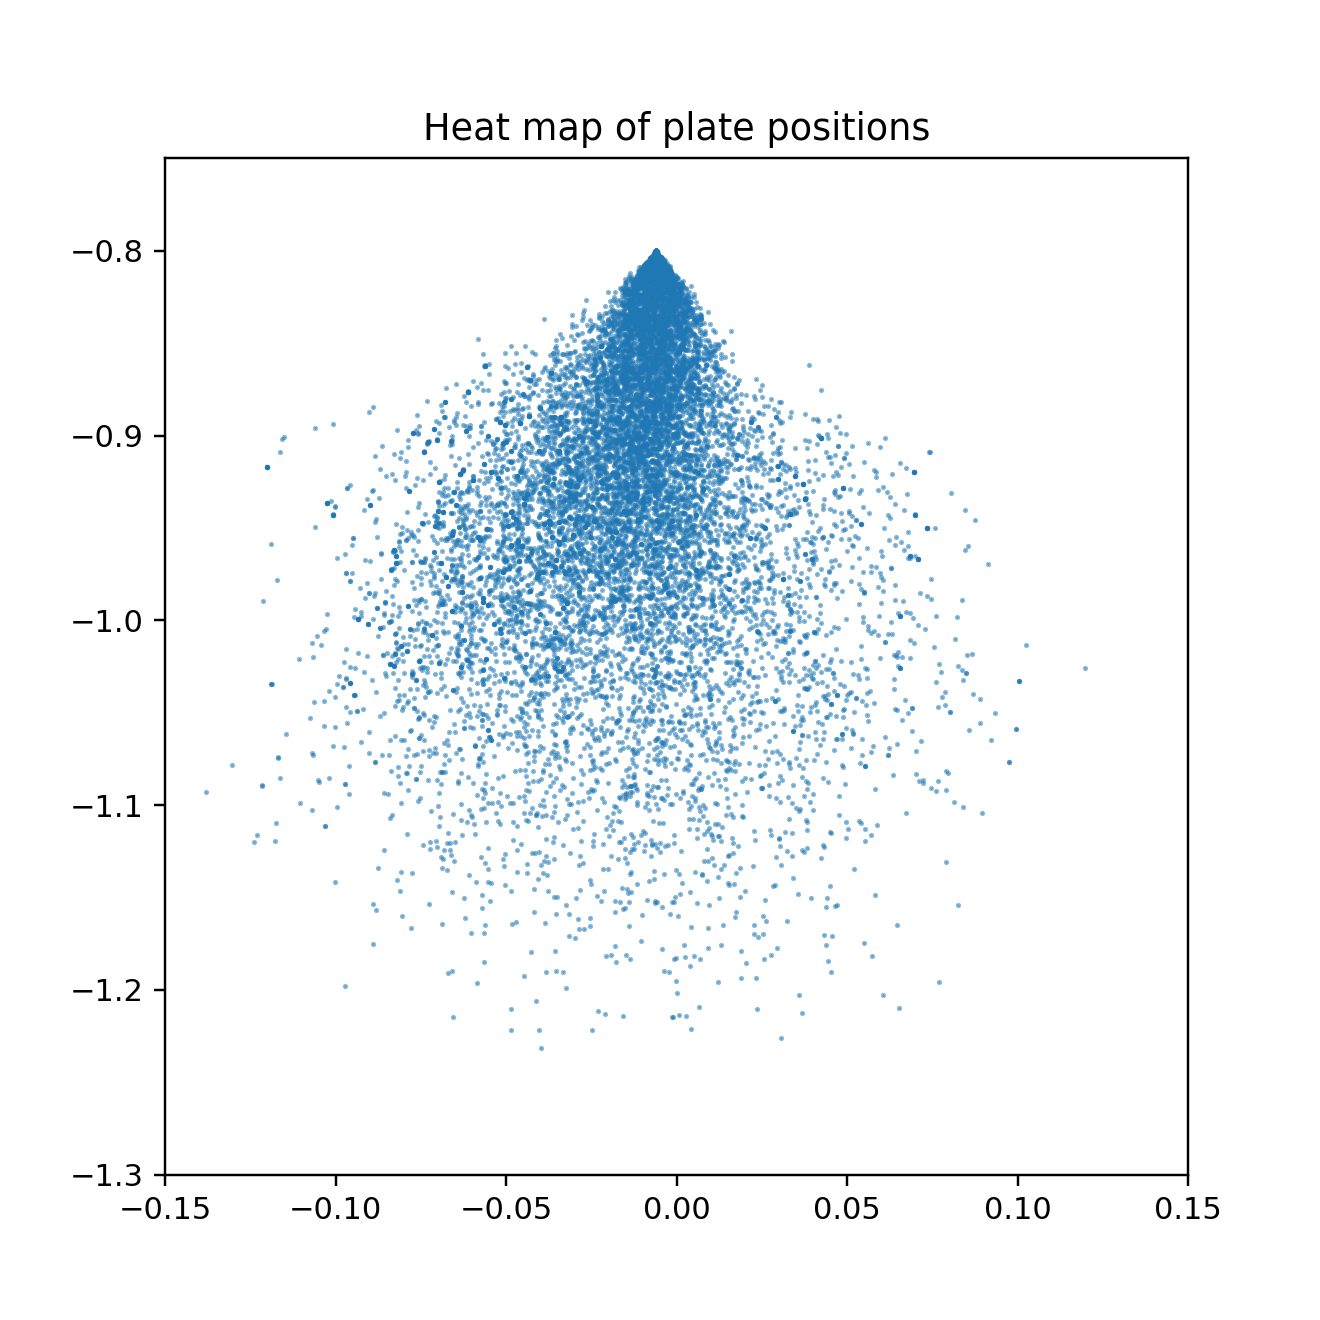

<IPython.core.display.Javascript object>


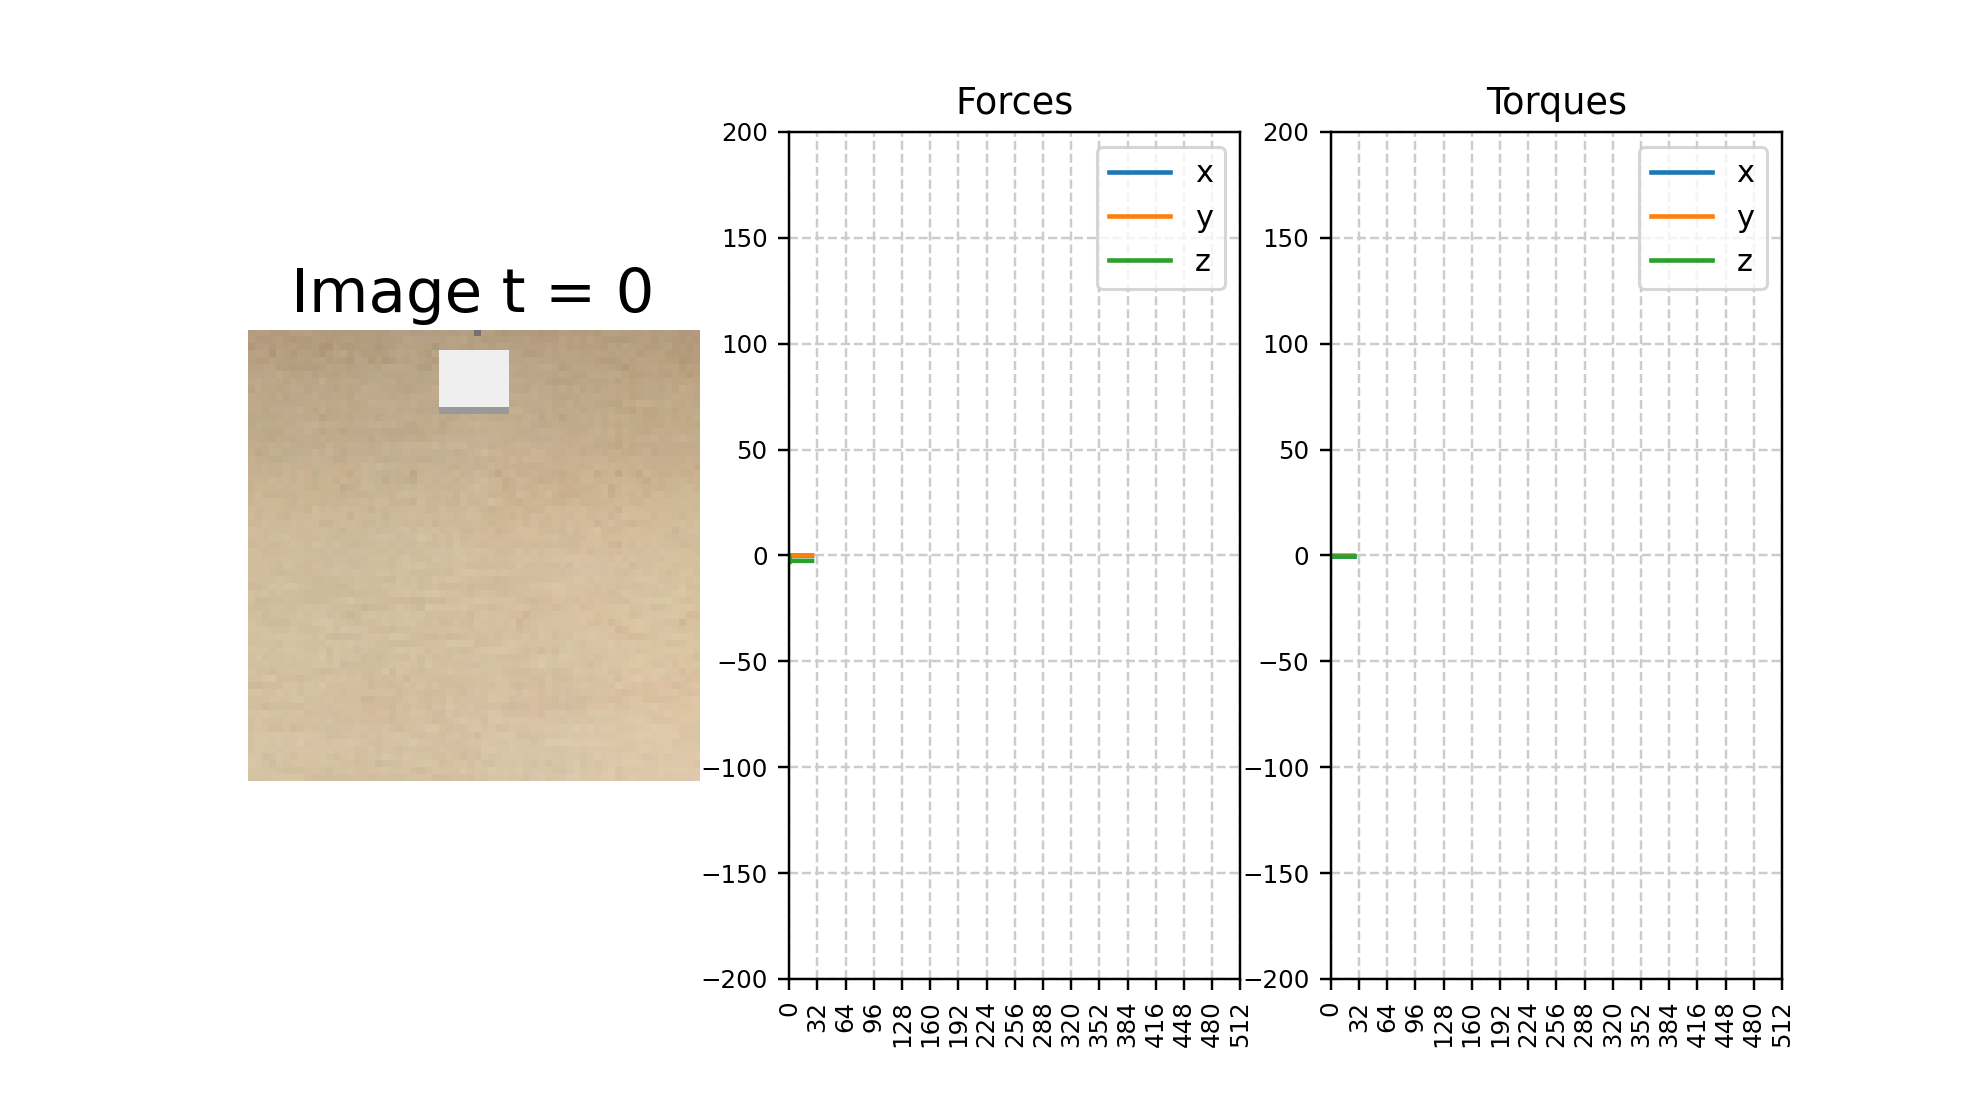

In [6]:
print(v)
hist = v.contact_norm_hist()
heatmap = v.plate_loc_heat_map()
anim = v.animate_traj(500)